In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from state_space_setup import *
from policy_df_generator import *

In [2]:
Optim_policy = pd.read_csv('policy.csv')
Optim_policy['State'] = Optim_policy['State'].apply(lambda x: tuple(map(int, x.strip('()').split(','))))

maximum_parts = Optim_policy['State'].apply(lambda x: x[0]).max()
print("Maximum number of parts in the inventory:", maximum_parts)

state_space = get_state_space(maximum_parts)

Maximum number of parts in the inventory: 41


In [3]:
Luke_policy = generate_sS_policy_IL(s=7, S=8, max_parts=maximum_parts)
Luke_policy["IL"] = list(map(lambda x: x[0], state_space))
Luke_policy["IP"] = list(map(sum, state_space))
Luke_policy.loc[(Luke_policy["IL"] >= 8) & (Luke_policy["IL"] <= 10) & (Luke_policy["IP"] <= 39), "Order_size"] += 2
Luke_policy.loc[(Luke_policy["IL"] >= 8) & (Luke_policy["IL"] <= 10) & (Luke_policy["IP"] == 40), "Order_size"] += 1
Luke_policy.drop('IL', axis=1, inplace=True)
Luke_policy.drop('IP', axis=1, inplace=True)
Luke_policy.to_csv("intern_policies/Luke.csv", index=False)


In [4]:
Ben_policy = generate_sS_policy_IL(s=9, S=14, max_parts=maximum_parts)
Ben_policy.to_csv("intern_policies/Ben.csv", index=False)

In [5]:
discount_factor = 0.995
cost_matrix = np.load("cost_matrix.npy")

def generate_demand(num_periods=1000, lambda_=2, p=0.9):
    demand = np.random.poisson(lam=lambda_, size=num_periods)
    arrivals = np.random.binomial(1, p, size=num_periods)

    return np.column_stack((demand, arrivals))


def apply_policy(initial_state, policy_df, demands):
    global maximum_parts, cost_matrix

    num_periods = len(demands)
    policy_dict = dict(zip(policy_df["State"], policy_df["Order_size"]))

    states = np.zeros((num_periods + 1, 2), dtype=int)
    actions = np.zeros(num_periods + 1, dtype=int)
    costs = np.zeros(num_periods + 1, dtype=float)

    states[0] = initial_state
    actions[0] = policy_dict[tuple(states[0])]
    costs[0] = 0

    for i in range(num_periods):
        current_state = states[i]
        current_idx = get_index(current_state[0], current_state[1], maximum_parts)
        action = actions[i]

        new_IL = max(0, current_state[0] - demands[i, 0]) + (current_state[1] + action) * demands[i, 1]
        new_OP = (current_state[1] + action) * (1 - demands[i, 1])
        
        new_idx = get_index(new_IL, new_OP, maximum_parts)
        cost = cost_matrix[current_idx, new_idx, action]
        costs[i+1] = cost

        states[i+1] = (new_IL, new_OP)
        actions[i+1] = policy_dict[(new_IL, new_OP)]

    SAC_df = pd.DataFrame({
        "States" : [tuple(s) for s in states],
        "Actions" : actions,
        "Costs" : costs
    })
    
    return SAC_df


def total_cost(simulated_data):
    global discount_factor
    
    factor_sequence = discount_factor ** np.arange(len(simulated_data["Costs"]))
    discounted_cost = np.sum(factor_sequence * np.array(simulated_data["Costs"]))
        
    return discounted_cost

In [6]:
state = (14, 0)
size = 1000
state_idx = get_index(state[0], state[1], maximum_parts)
sampled_costs_Luke = np.zeros(size)
sampled_costs_Ben = np.zeros(size)
sampled_costs_Optim = np.zeros(size)

for i in range(size):
    demand = generate_demand(4000, 2, 0.9)
    sampled_costs_Luke[i] = total_cost(apply_policy(state, Luke_policy, demand))
    sampled_costs_Ben[i] = total_cost(apply_policy(state, Ben_policy, demand))
    sampled_costs_Optim[i] = total_cost(apply_policy(state, Optim_policy, demand))
    if (i + 1) % 100 == 0:
        print(f"Sample {i + 1}/{size}:\n \
            Optimal policy cost = {sampled_costs_Optim[i]},\n \
            Luke's policy cost = {sampled_costs_Luke[i]},\n \
            Ben's policy cost = {sampled_costs_Ben[i]}")

Sample 100/1000:
             Optimal policy cost = 45212.31300379144,
             Luke's policy cost = 101706.02139742524,
             Ben's policy cost = 53440.97437230185
Sample 200/1000:
             Optimal policy cost = 47607.50954228468,
             Luke's policy cost = 136331.28042279778,
             Ben's policy cost = 58372.38875662064
Sample 300/1000:
             Optimal policy cost = 49590.81137856828,
             Luke's policy cost = 132304.63286991938,
             Ben's policy cost = 59240.9936779344
Sample 400/1000:
             Optimal policy cost = 51212.447288642106,
             Luke's policy cost = 118269.44823023262,
             Ben's policy cost = 57327.32188923264
Sample 500/1000:
             Optimal policy cost = 47190.18677866421,
             Luke's policy cost = 114930.70769381642,
             Ben's policy cost = 55200.95638248296
Sample 600/1000:
             Optimal policy cost = 46670.51172012058,
             Luke's policy cost = 117976.84946146

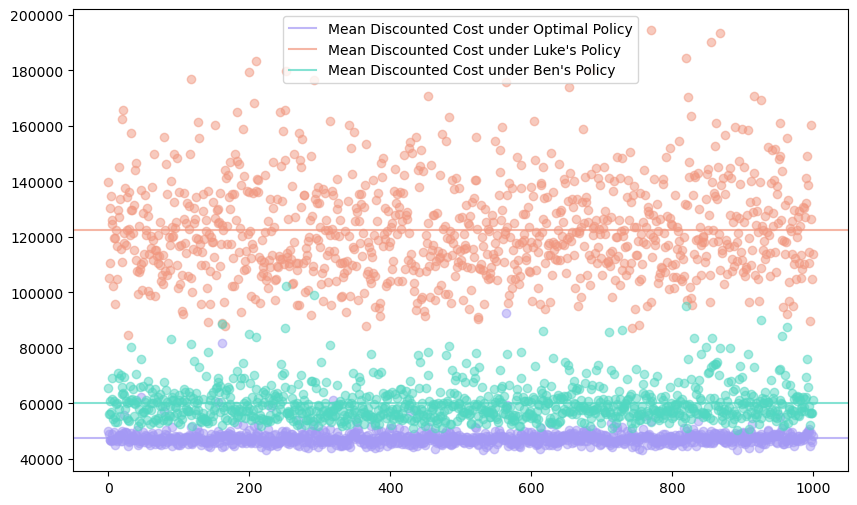

The mean of the sampled costs under optimal policy: 47611.57711123177
The mean of the sampled costs under Luke's policy: 122526.88616893532
The mean of the sampled costs under Ben's policy 60227.754991050904


In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(sampled_costs_Optim)), sampled_costs_Optim, color='#A499F4', alpha=0.5)
plt.scatter(np.arange(len(sampled_costs_Luke)), sampled_costs_Luke, color='#F1977F', alpha=0.5)
plt.scatter(np.arange(len(sampled_costs_Ben)), sampled_costs_Ben, color='#51D7C1', alpha=0.5)
plt.axhline(np.mean(sampled_costs_Optim), color='#A499F4', linestyle='-', label='Mean Discounted Cost under Optimal Policy', alpha=0.7)
plt.axhline(np.mean(sampled_costs_Luke), color='#F1977F', linestyle='-', label='Mean Discounted Cost under Luke\'s Policy', alpha=0.7)
plt.axhline(np.mean(sampled_costs_Ben), color='#51D7C1', linestyle='-', label='Mean Discounted Cost under Ben\'s Policy', alpha=0.7)
plt.legend()
plt.savefig("plots/intern_policies.pdf", format="pdf", bbox_inches='tight')
plt.show()

print("The mean of the sampled costs under optimal policy:", np.mean(sampled_costs_Optim))
print("The mean of the sampled costs under Luke's policy:", np.mean(sampled_costs_Luke))
print("The mean of the sampled costs under Ben's policy", np.mean(sampled_costs_Ben))
